<a href="https://colab.research.google.com/github/Igor-ID/g.tec-BR41N.IO-Hackathon-Unresponsive-Wakefulness-Syndrome/blob/main/gtec_hackathon_UWS_P300.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
%matplotlib inline
!pip install mne
!pip install pyriemann
import mne
import matplotlib.pyplot as plt
import scipy
import os
from scipy.io import loadmat
import numpy as np
import mne
import pandas as pd
import seaborn as sns
from mne.decoding import Vectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from collections import OrderedDict
import pandas as pd
from sklearn.pipeline import make_pipeline

from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import ERPCovariances, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Helper func to create epochs object

In [28]:
def create_epochs(starting_dir="/content/drive/My Drive/data/", item='P1_high1.mat'):
    eeg_ch = ['Fz', 'C3', 'Cz', 'C4', 'CP1', 'CPz', 'CP2', 'Pz']
    fs = 256 # frequency
    n_channels = 8
    info = mne.create_info(ch_names=eeg_ch, sfreq=fs, ch_types='eeg')
    info.set_montage('standard_1020')
    file_name = os.path.join(starting_dir, item)
    data = loadmat(file_name) # converting .mat to numpy array
    eeg_data = data['y']
    eeg_data = eeg_data * 1e-6 # converting from uV to V

    raw = mne.io.RawArray(eeg_data.T, info)
    stim_data = data['trig'] # retrieving triggers
    # changing stimulus value from -1 to 1 since we need to classify between target vs all other stimuli
    stim_data[stim_data == -1] = 1
    info_event = mne.create_info(['STI'], sfreq=fs, ch_types='stim')
    stim_raw = mne.io.RawArray(stim_data.T, info_event)
    raw.add_channels([stim_raw], force_update_info=True) # adding trigger channel to the raw MNE object

    events = mne.find_events(raw, stim_channel='STI') # getting all events
    event_id = {'nontarget': 1, 'target': 2}
    raw.notch_filter(freqs=50)  # creating band-stop filter to remove power line noise (US - 60Hz, EU - 50Hz)
    raw.filter(l_freq=0.1, h_freq=30)  # creating band-pass filter, to remove non-physiological frequencies

    epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-0.1, tmax=0.6, reject={'eeg': 100e-6}, preload=True)
    return epochs

Take the data of the first subject (P1_high)

In [29]:
epochs_P1_high1 = create_epochs()
epochs_P1_high2 = create_epochs(item='P1_high2.mat')
# Concatenating the two files because we do not need to have training and testing separately when using cross-validation.
epochs_train = mne.concatenate_epochs([epochs_P1_high1, epochs_P1_high2])
epochs_train.pick_types(eeg=True)
X = epochs_train.get_data()  # features
y = epochs_train.events[:, -1]  # labels
X, y, X.shape, y.shape

Creating RawArray with float64 data, n_channels=8, n_times=38976
    Range : 0 ... 38975 =      0.000 ...   152.246 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=38976
    Range : 0 ... 38975 =      0.000 ...   152.246 secs
Ready.
480 events found
Event IDs: [1 2]
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass 

(array([[[-1.73926353e-05, -1.91928221e-05, -2.14450772e-05, ...,
           5.34220556e-06, -2.56244221e-07, -4.81489551e-06],
         [-1.03376614e-05, -1.20804882e-05, -1.41910149e-05, ...,
           3.83773912e-06,  4.08800201e-07, -2.72862412e-06],
         [-1.50375802e-05, -1.68690122e-05, -1.87448544e-05, ...,
           1.01016948e-05,  4.72040590e-06, -1.41307361e-07],
         ...,
         [-1.26141264e-05, -1.45919774e-05, -1.63169868e-05, ...,
           4.52273181e-06, -1.19877254e-06, -6.40834764e-06],
         [-1.14450576e-05, -1.32930601e-05, -1.52907066e-05, ...,
           1.60760751e-05,  1.01746171e-05,  4.31416866e-06],
         [-8.68670464e-06, -1.08900082e-05, -1.29845991e-05, ...,
           1.05879163e-05,  4.85713451e-06, -7.83720318e-07]],
 
        [[-2.36912552e-05, -2.59533072e-05, -2.84222838e-05, ...,
           2.34055872e-05,  2.53967832e-05,  2.84844407e-05],
         [-7.26549756e-06, -9.73585104e-06, -1.15535804e-05, ...,
           2.18698838

Visualizing the epochs

Opening epochs-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


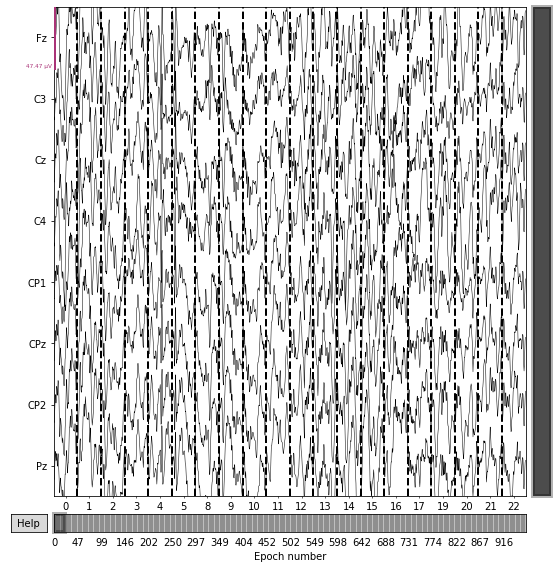

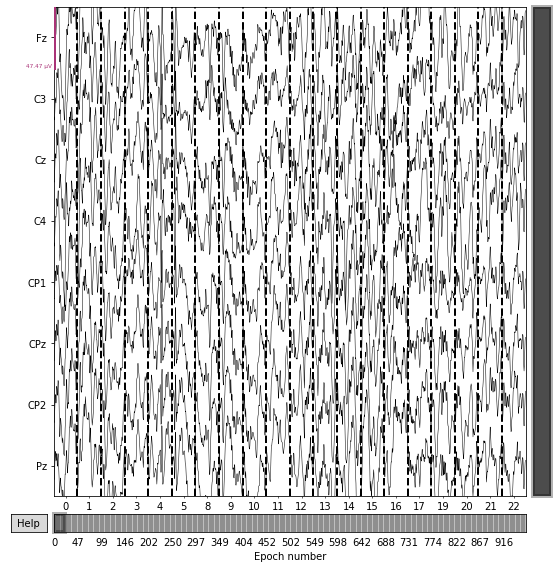

In [30]:
epochs_train.plot(scalings='auto')

Next, let's take a look at the averaged representation of all epochs with respect to target and non-target stimuli.

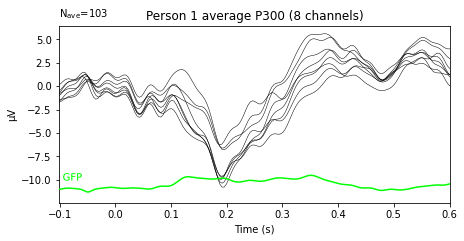

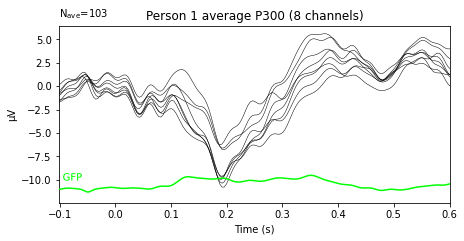

In [31]:
evoked = epochs_train['target'].average()
evoked.plot(gfp=True, titles='Person 1 average P300')

combining channels using "gfp"
combining channels using "gfp"


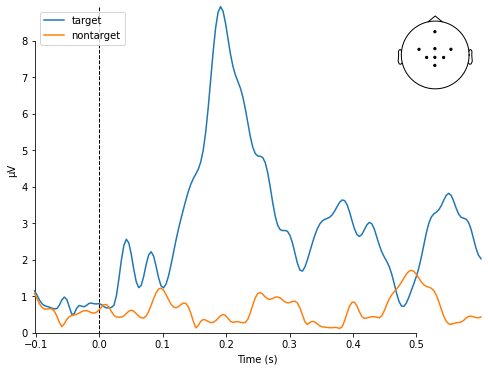

[<Figure size 576x432 with 2 Axes>]

In [32]:
evoked_nontarget = epochs_train['nontarget'].average()

mne.viz.plot_compare_evokeds(dict(target=evoked, nontarget=evoked_nontarget),
                             legend='upper left', show_sensors='upper right')

Text(0.5, 1.0, "First epoch of 'C3' channel")

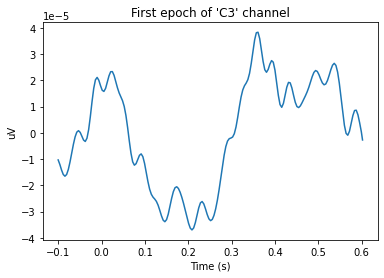

In [33]:
# Visualization of the first epoch of a single channel.
time = np.arange(-0.1, 0.6, 1/256)
t = np.append(time, 0.602)
t.shape
plt.plot(t, X[0][1])
plt.xlabel('Time (s)') 
plt.ylabel('uV')
plt.title("First epoch of 'C3' channel")

Topomaps

No projector specified for this dataset. Please consider the method self.add_proj.


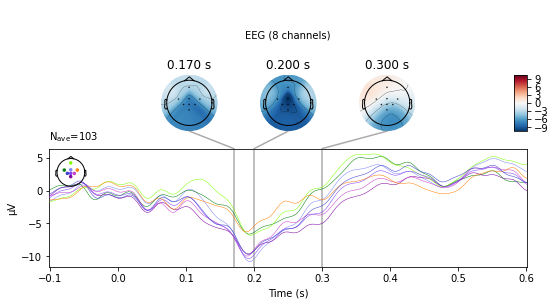

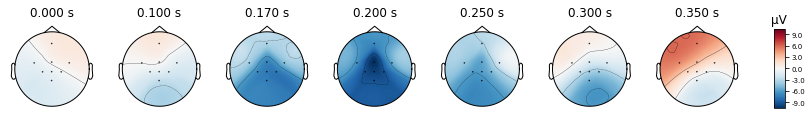

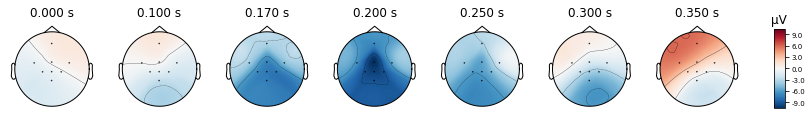

In [34]:
evoked.plot_joint(times=[0.170, 0.200, 0.300], picks='eeg')
evoked.plot_topomap(times=[0., 0.1, 0.17, 0.2, 0.25, 0.3, 0.35], ch_type='eeg')

Creating 6 different machine learning pipelines to classify the P300 ERP

In [35]:
clfs = OrderedDict()

clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(estimator='oas'), MDM())
clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, 
                            random_state=42)

In [36]:
# run cross validation for each pipeline
acc = []
methods = []
for m in clfs:
    print(m)
    try:
        
        res = cross_val_score(clfs[m], X, y, scoring='accuracy', 
                              cv=cv, n_jobs=-1)
        print(res)
        acc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass

Vect + LR
[0.82325581 0.80465116 0.81860465 0.85116279 0.80465116 0.82325581
 0.81860465 0.86976744 0.80465116 0.78139535]
Vect + RegLDA
[0.8372093  0.83255814 0.81860465 0.85581395 0.84651163 0.82790698
 0.81395349 0.86976744 0.82325581 0.80930233]
ERPCov + TS
[0.86511628 0.87906977 0.84186047 0.88372093 0.8744186  0.86976744
 0.8744186  0.8744186  0.88372093 0.86976744]
ERPCov + MDM
[0.62790698 0.6744186  0.70232558 0.65116279 0.6744186  0.69767442
 0.64651163 0.70697674 0.70697674 0.64651163]
XdawnCov + TS
[0.85581395 0.8744186  0.84186047 0.88837209 0.88837209 0.8744186
 0.86511628 0.87906977 0.88372093 0.8744186 ]
XdawnCov + MDM
[0.60930233 0.64651163 0.70232558 0.70697674 0.72093023 0.71162791
 0.66511628 0.71627907 0.73023256 0.68372093]


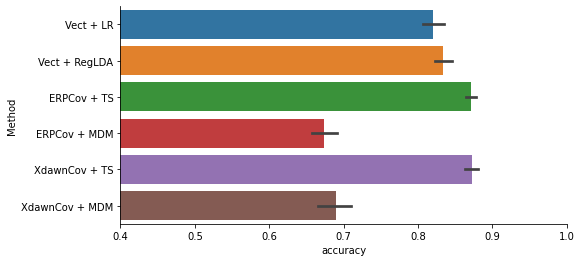

In [37]:
# Plot Decoding Results
results = pd.DataFrame(data=acc, columns=['accuracy'])
results['Method'] = methods

fig = plt.figure(figsize=[8,4])
sns.barplot(data=results, x='accuracy', y='Method')
plt.xlim(0.4, 1.0)
sns.despine()


Let's implement the same steps for the second person.

In [38]:
epochs_P2_high1 = create_epochs(item='P2_high1.mat')
epochs_P2_high2 = create_epochs(item='P2_high2.mat')
# Concatenating the two files because we do not need to have training and testing separately when using cross-validation.
epochs_train_P2 = mne.concatenate_epochs([epochs_P2_high1, epochs_P2_high2])
epochs_train_P2.pick_types(eeg=True)
X = epochs_train_P2.get_data()  # features
y = epochs_train_P2.events[:, -1]  # labels
X, y, X.shape, y.shape

Creating RawArray with float64 data, n_channels=8, n_times=39280
    Range : 0 ... 39279 =      0.000 ...   153.434 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=39280
    Range : 0 ... 39279 =      0.000 ...   153.434 secs
Ready.
480 events found
Event IDs: [1 2]
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass 

(array([[[ 5.31782667e-06, -8.90668690e-06, -1.86653118e-05, ...,
           6.58672220e-06, -7.23402312e-06, -1.82156209e-05],
         [ 1.32703179e-07, -1.33235240e-05, -2.23148878e-05, ...,
          -5.82834357e-07, -7.93764448e-06, -1.60766143e-05],
         [ 8.24200042e-06, -5.54942808e-06, -1.50088086e-05, ...,
          -4.10304268e-06, -1.36972934e-05, -2.30260737e-05],
         ...,
         [-8.49555294e-06, -1.74335166e-05, -2.25014574e-05, ...,
          -1.59657907e-05, -2.38150217e-05, -3.23068348e-05],
         [ 4.28450232e-06, -9.48645891e-06, -1.84823807e-05, ...,
           8.98733292e-06, -4.43415604e-06, -1.49270595e-05],
         [ 3.53624254e-06, -9.84956469e-06, -1.82701003e-05, ...,
           1.17189675e-05, -2.13066842e-06, -1.31069470e-05]],
 
        [[ 2.80284201e-06, -9.66010751e-06, -1.76552822e-05, ...,
          -1.51455286e-05, -1.69432752e-05, -1.51460597e-05],
         [ 4.12355584e-06, -7.65342372e-06, -1.63593579e-05, ...,
          -5.11790552

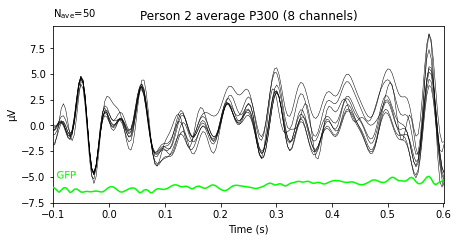

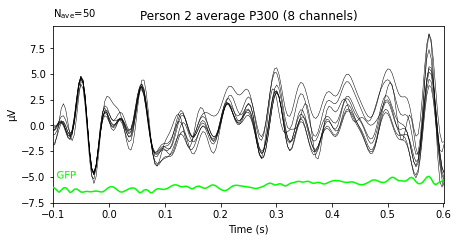

In [39]:
evoked = epochs_train_P2['target'].average()
evoked.plot(gfp=True, titles='Person 2 average P300')

combining channels using "gfp"
combining channels using "gfp"


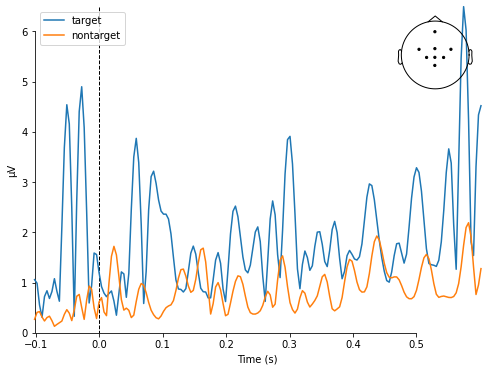

[<Figure size 576x432 with 2 Axes>]

In [40]:
evoked_nontarget = epochs_train_P2['nontarget'].average()

mne.viz.plot_compare_evokeds(dict(target=evoked, nontarget=evoked_nontarget),
                             legend='upper left', show_sensors='upper right')

In [41]:
# run cross validation for each pipeline
acc = []
methods = []
for m in clfs:
    print(m)
    try:
        
        res = cross_val_score(clfs[m], X, y, scoring='accuracy', 
                              cv=cv, n_jobs=-1)
        print(res)
        acc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass

Vect + LR
[0.74528302 0.79245283 0.80188679 0.83962264 0.76415094 0.75471698
 0.79245283 0.83018868 0.83962264 0.79245283]
Vect + RegLDA
[0.83962264 0.81132075 0.79245283 0.82075472 0.83018868 0.74528302
 0.82075472 0.85849057 0.86792453 0.78301887]
ERPCov + TS
[0.87735849 0.83018868 0.83962264 0.88679245 0.85849057 0.8490566
 0.85849057 0.87735849 0.8490566  0.86792453]
ERPCov + MDM
[0.64150943 0.66037736 0.50943396 0.63207547 0.56603774 0.63207547
 0.63207547 0.68867925 0.6509434  0.62264151]
XdawnCov + TS
[0.86792453 0.8490566  0.88679245 0.86792453 0.86792453 0.83962264
 0.87735849 0.86792453 0.85849057 0.87735849]
XdawnCov + MDM
[0.6509434  0.6509434  0.5754717  0.59433962 0.49056604 0.66981132
 0.60377358 0.66037736 0.66037736 0.5754717 ]


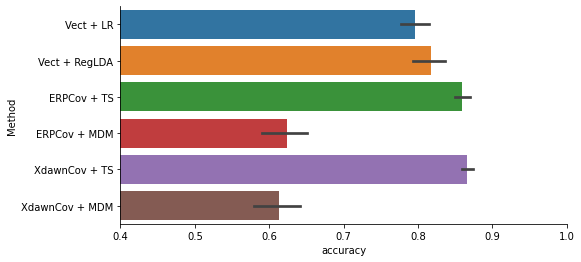

In [42]:
# Plot Decoding Results
results = pd.DataFrame(data=acc, columns=['accuracy'])
results['Method'] = methods

fig = plt.figure(figsize=[8,4])
sns.barplot(data=results, x='accuracy', y='Method')
plt.xlim(0.4, 1.0)
sns.despine()

Let's do the same for the low part of the data.

In [43]:
epochs_P2_low1 = create_epochs(item='P2_low1.mat')
epochs_P2_low2 = create_epochs(item='P2_low2.mat')
# Concatenating the two files because we do not need to have training and testing separately when using cross-validation.
epochs_train_P2l = mne.concatenate_epochs([epochs_P2_low1, epochs_P2_low2])
epochs_train_P2l.pick_types(eeg=True)
X = epochs_train_P2l.get_data()  # features
y = epochs_train_P2l.events[:, -1]  # labels
X, y, X.shape, y.shape

Creating RawArray with float64 data, n_channels=8, n_times=39440
    Range : 0 ... 39439 =      0.000 ...   154.059 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=39440
    Range : 0 ... 39439 =      0.000 ...   154.059 secs
Ready.
480 events found
Event IDs: [1 2]
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass 

(array([[[ 2.67214361e-05,  1.53412013e-05, -7.85439696e-07, ...,
          -1.10767692e-05, -2.63661868e-05, -3.77188143e-05],
         [ 2.85369019e-05,  1.30877801e-05, -7.37122085e-06, ...,
          -3.36283377e-08, -1.61492280e-05, -2.69622346e-05],
         [ 2.96541334e-05,  1.78252798e-05,  1.03990184e-06, ...,
          -5.03944466e-06, -2.04316340e-05, -3.18713926e-05],
         ...,
         [ 2.99394291e-05,  1.95413948e-05,  4.19117849e-06, ...,
          -2.15502534e-06, -1.66788008e-05, -2.76158573e-05],
         [ 2.96615385e-05,  1.87889661e-05,  2.96547842e-06, ...,
          -3.89348584e-06, -1.85733901e-05, -2.97860974e-05],
         [ 3.23742350e-05,  2.13475280e-05,  5.50438207e-06, ...,
          -1.60369418e-06, -1.63673674e-05, -2.73488287e-05]],
 
        [[ 1.41278757e-05,  1.72560187e-05,  1.57734318e-05, ...,
          -4.15943724e-05, -4.32266989e-05, -3.78312752e-05],
         [ 1.04644621e-05,  9.70720459e-06,  4.67853716e-06, ...,
          -4.17773653

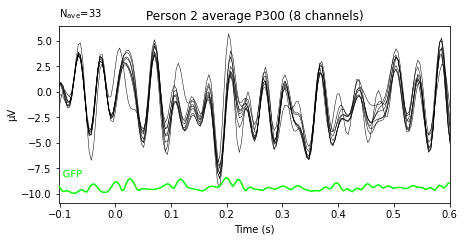

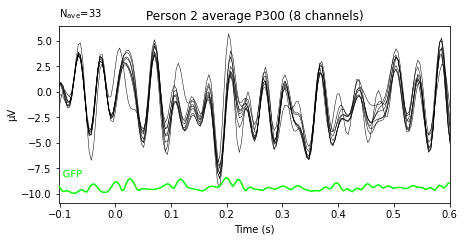

In [44]:
evoked = epochs_train_P2l['target'].average()
evoked.plot(gfp=True, titles='Person 2 average P300')

combining channels using "gfp"
combining channels using "gfp"


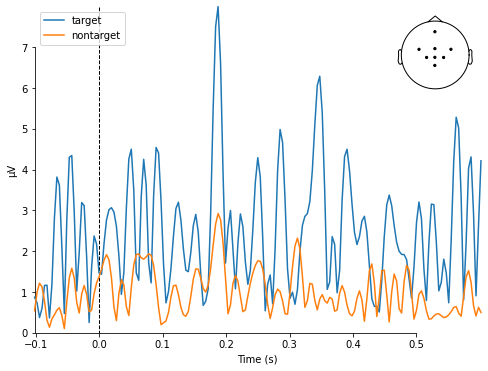

[<Figure size 576x432 with 2 Axes>]

In [45]:
evoked_nontarget = epochs_train_P2l['nontarget'].average()

mne.viz.plot_compare_evokeds(dict(target=evoked, nontarget=evoked_nontarget),
                             legend='upper left', show_sensors='upper right')

In [46]:
# run cross validation for each pipeline
acc = []
methods = []
for m in clfs:
    print(m)
    try:
        
        res = cross_val_score(clfs[m], X, y, scoring='accuracy', 
                              cv=cv, n_jobs=-1)
        print(res)
        acc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass

Vect + LR
[0.81034483 0.74137931 0.82758621 0.74137931 0.67241379 0.72413793
 0.77586207 0.65517241 0.81034483 0.70689655]
Vect + RegLDA
[0.81034483 0.74137931 0.77586207 0.75862069 0.62068966 0.74137931
 0.74137931 0.65517241 0.86206897 0.79310345]
ERPCov + TS
[0.84482759 0.86206897 0.86206897 0.86206897 0.86206897 0.87931034
 0.87931034 0.84482759 0.86206897 0.84482759]
ERPCov + MDM
[0.63793103 0.55172414 0.56896552 0.65517241 0.63793103 0.4137931
 0.60344828 0.4137931  0.62068966 0.63793103]
XdawnCov + TS
[0.84482759 0.84482759 0.86206897 0.86206897 0.86206897 0.87931034
 0.87931034 0.82758621 0.84482759 0.84482759]
XdawnCov + MDM
[0.74137931 0.63793103 0.70689655 0.63793103 0.74137931 0.62068966
 0.65517241 0.51724138 0.74137931 0.74137931]


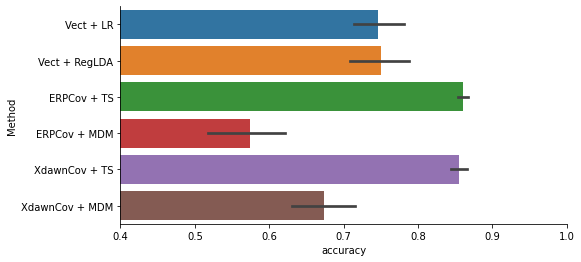

In [47]:
# Plot Decoding Results
results = pd.DataFrame(data=acc, columns=['accuracy'])
results['Method'] = methods

fig = plt.figure(figsize=[8,4])
sns.barplot(data=results, x='accuracy', y='Method')
plt.xlim(0.4, 1.0)
sns.despine()

In [48]:
# Same for the P1 low
epochs_P1_low1 = create_epochs(item='P1_low1.mat')
epochs_P1_low2 = create_epochs(item='P1_low2.mat')
# Concatenating the two files because we do not need to have training and testing separately when using cross-validation.
epochs_train_P1l = mne.concatenate_epochs([epochs_P1_low1, epochs_P1_low2])
epochs_train_P1l.pick_types(eeg=True)
X = epochs_train_P1l.get_data()  # features
y = epochs_train_P1l.events[:, -1]  # labels
X, y, X.shape, y.shape

Creating RawArray with float64 data, n_channels=8, n_times=39056
    Range : 0 ... 39055 =      0.000 ...   152.559 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=39056
    Range : 0 ... 39055 =      0.000 ...   152.559 secs
Ready.
480 events found
Event IDs: [1 2]
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass 

(array([[[-9.17901571e-08, -2.64783708e-06, -5.27337506e-06, ...,
           7.74507671e-06,  1.08141841e-05,  1.42454085e-05],
         [ 4.78688905e-06,  3.20952148e-06,  5.96943209e-07, ...,
           4.57939352e-06,  5.88159683e-06,  7.39779703e-06],
         [ 3.45299108e-06,  7.61933831e-07, -1.99108055e-06, ...,
           8.81616083e-06,  1.25680110e-05,  1.64259730e-05],
         ...,
         [ 1.08787216e-05,  8.57360943e-06,  5.99892638e-06, ...,
           2.36680964e-06,  5.49471947e-06,  9.03697395e-06],
         [ 1.19795877e-05,  8.72800909e-06,  4.87435918e-06, ...,
          -2.29882207e-06,  1.19146807e-06,  5.41162135e-06],
         [ 7.86396567e-06,  6.38007195e-06,  4.23294082e-06, ...,
           3.78320963e-06,  5.35945950e-06,  7.50548389e-06]],
 
        [[-2.50687886e-05, -2.57652250e-05, -2.44939248e-05, ...,
           3.58776514e-07, -8.88637872e-07, -8.58615401e-07],
         [-2.47276052e-05, -2.34016778e-05, -2.05715149e-05, ...,
           1.55685390

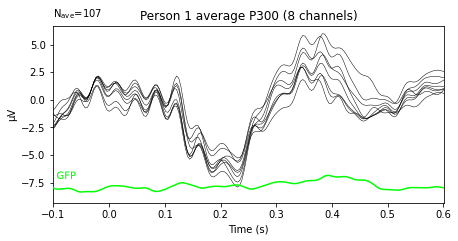

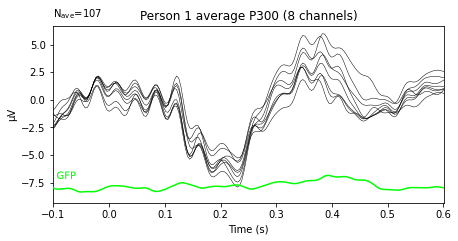

In [49]:
evoked = epochs_train_P1l['target'].average()
evoked.plot(gfp=True, titles='Person 1 average P300')

combining channels using "gfp"
combining channels using "gfp"


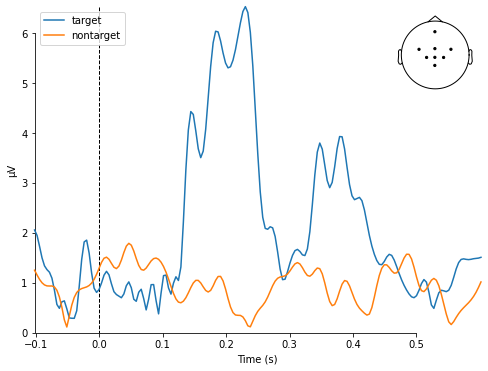

[<Figure size 576x432 with 2 Axes>]

In [50]:
evoked_nontarget = epochs_train_P1l['nontarget'].average()

mne.viz.plot_compare_evokeds(dict(target=evoked, nontarget=evoked_nontarget),
                             legend='upper left', show_sensors='upper right')

In [51]:
# run cross validation for each pipeline
acc = []
methods = []
for m in clfs:
    print(m)
    try:
        
        res = cross_val_score(clfs[m], X, y, scoring='accuracy', 
                              cv=cv, n_jobs=-1)
        print(res)
        acc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass

Vect + LR
[0.76995305 0.83568075 0.81690141 0.74647887 0.79342723 0.82159624
 0.78873239 0.77464789 0.82159624 0.77934272]
Vect + RegLDA
[0.8028169  0.81690141 0.84976526 0.80751174 0.88262911 0.83098592
 0.83098592 0.84037559 0.8028169  0.78403756]
ERPCov + TS
[0.84507042 0.84507042 0.85915493 0.84976526 0.87323944 0.85915493
 0.87323944 0.84976526 0.85915493 0.84507042]
ERPCov + MDM
[0.61971831 0.53051643 0.57276995 0.657277   0.5915493  0.62441315
 0.54929577 0.55399061 0.54929577 0.56338028]
XdawnCov + TS
[0.87793427 0.85446009 0.86384977 0.86384977 0.87323944 0.85446009
 0.8685446  0.84037559 0.85446009 0.86384977]
XdawnCov + MDM
[0.657277   0.58685446 0.68544601 0.63380282 0.61032864 0.70422535
 0.62910798 0.66666667 0.62910798 0.59624413]


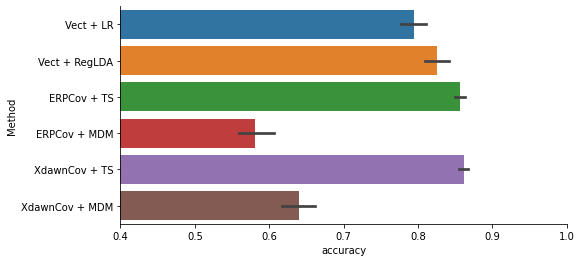

In [52]:
# Plot Decoding Results
results = pd.DataFrame(data=acc, columns=['accuracy'])
results['Method'] = methods

fig = plt.figure(figsize=[8,4])
sns.barplot(data=results, x='accuracy', y='Method')
plt.xlim(0.4, 1.0)
sns.despine()

Combining patient 1 and patient 2 and classifying between the two patients

In [57]:
# Combining P1_high and P2_high
# Getting only "target" epochs, since we need to distinguish between targets of two different persons
P1h = epochs_train['target']
P2h = epochs_train_P2['target']
X1h = P1h.get_data()  # features
y1h = P1h.events[:, -1]  # labels
# Since the "target" label is 2 for each person,  let's swap the target to 1 for the 1st person
y1h[y1h == 2] = 1
X2h = P2h.get_data()
y2h = P2h.events[:, -1]
# Concatenating features and labels
X_final = np.concatenate((X1h, X2h), axis=0)
y_final = np.concatenate((y1h, y2h), axis=0)
X_final, y_final, X_final.shape, y_final.shape

(array([[[-1.73926353e-05, -1.91928221e-05, -2.14450772e-05, ...,
           5.34220556e-06, -2.56244221e-07, -4.81489551e-06],
         [-1.03376614e-05, -1.20804882e-05, -1.41910149e-05, ...,
           3.83773912e-06,  4.08800201e-07, -2.72862412e-06],
         [-1.50375802e-05, -1.68690122e-05, -1.87448544e-05, ...,
           1.01016948e-05,  4.72040590e-06, -1.41307361e-07],
         ...,
         [-1.26141264e-05, -1.45919774e-05, -1.63169868e-05, ...,
           4.52273181e-06, -1.19877254e-06, -6.40834764e-06],
         [-1.14450576e-05, -1.32930601e-05, -1.52907066e-05, ...,
           1.60760751e-05,  1.01746171e-05,  4.31416866e-06],
         [-8.68670464e-06, -1.08900082e-05, -1.29845991e-05, ...,
           1.05879163e-05,  4.85713451e-06, -7.83720318e-07]],
 
        [[-1.85580931e-06, -2.16596264e-06, -2.73239060e-06, ...,
          -4.27352219e-06, -6.82679925e-06, -1.12169623e-05],
         [ 4.74134196e-07,  7.28612859e-08, -7.73887704e-07, ...,
          -6.54542748

Let's create the visualization again to make sure there is a difference between person 1 and person 2.

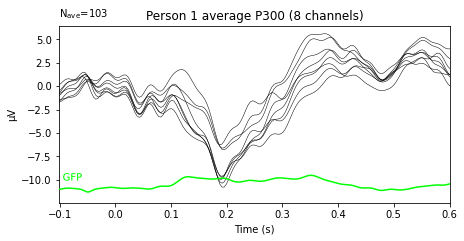

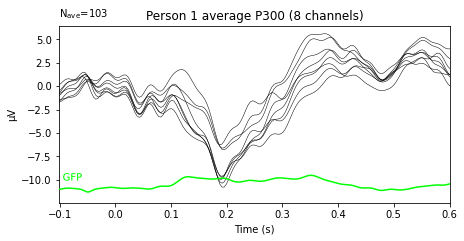

In [58]:
evokedP1 = P1h.average()
evokedP1.plot(gfp=True, titles='Person 1 average P300')

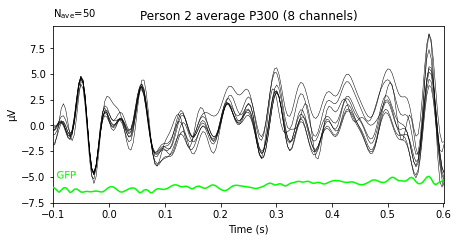

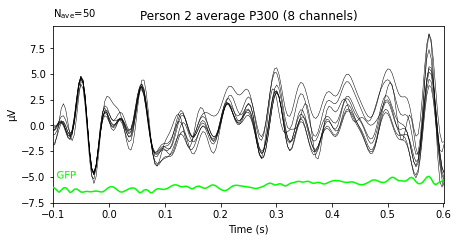

In [59]:
evokedP2 = P2h.average()
evokedP2.plot(gfp=True, titles='Person 2 average P300')

In [60]:
# run cross validation for each pipeline
acc = []
methods = []
for m in clfs:
    print(m)
    try:
        
        res = cross_val_score(clfs[m], X_final, y_final, scoring='accuracy', 
                              cv=cv, n_jobs=-1)
        print(res)
        acc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass

Vect + LR
[0.71794872 0.76923077 0.69230769 0.71794872 0.71794872 0.69230769
 0.69230769 0.69230769 0.61538462 0.74358974]
Vect + RegLDA
[0.64102564 0.76923077 0.66666667 0.69230769 0.66666667 0.66666667
 0.71794872 0.69230769 0.61538462 0.66666667]
ERPCov + TS
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ERPCov + MDM
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
XdawnCov + TS
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
XdawnCov + MDM
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


All four pipelines based on Riemannian geometry can distinguish between the presence or absence of ERP P300 response to stimuli with 100% accuracy

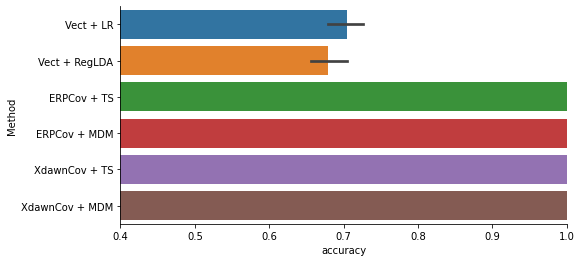

In [61]:
# Plot Decoding Results
results = pd.DataFrame(data=acc, columns=['accuracy'])
results['Method'] = methods

fig = plt.figure(figsize=[8,4])
sns.barplot(data=results, x='accuracy', y='Method')
plt.xlim(0.4, 1.0)
sns.despine()

In [62]:
# Combining P1_low and P2_low
# Getting only "target" epochs, since we need to distinguish between targets of two different persons
P1l = epochs_train_P1l['target']
P2l = epochs_train_P2l['target']
X1l = P1l.get_data()  # features
y1l = P1l.events[:, -1]  # labels
# Since the "target" label is 2 for each person,  let's swap the target to 1 for the 1st person
y1l[y1l == 2] = 1
X2l = P2l.get_data()
y2l = P2l.events[:, -1]
# Concatenating features and labels
X_final = np.concatenate((X1l, X2l), axis=0)
y_final = np.concatenate((y1l, y2l), axis=0)
X_final, y_final, X_final.shape, y_final.shape

(array([[[-9.17901571e-08, -2.64783708e-06, -5.27337506e-06, ...,
           7.74507671e-06,  1.08141841e-05,  1.42454085e-05],
         [ 4.78688905e-06,  3.20952148e-06,  5.96943209e-07, ...,
           4.57939352e-06,  5.88159683e-06,  7.39779703e-06],
         [ 3.45299108e-06,  7.61933831e-07, -1.99108055e-06, ...,
           8.81616083e-06,  1.25680110e-05,  1.64259730e-05],
         ...,
         [ 1.08787216e-05,  8.57360943e-06,  5.99892638e-06, ...,
           2.36680964e-06,  5.49471947e-06,  9.03697395e-06],
         [ 1.19795877e-05,  8.72800909e-06,  4.87435918e-06, ...,
          -2.29882207e-06,  1.19146807e-06,  5.41162135e-06],
         [ 7.86396567e-06,  6.38007195e-06,  4.23294082e-06, ...,
           3.78320963e-06,  5.35945950e-06,  7.50548389e-06]],
 
        [[-7.16076590e-06, -8.94012564e-06, -1.05034282e-05, ...,
           5.14582918e-05,  5.10243051e-05,  5.08422427e-05],
         [ 5.51404673e-06,  2.41157785e-06,  2.31570566e-07, ...,
           4.69235618

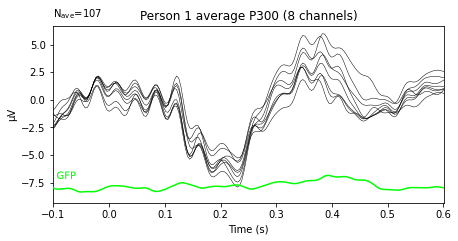

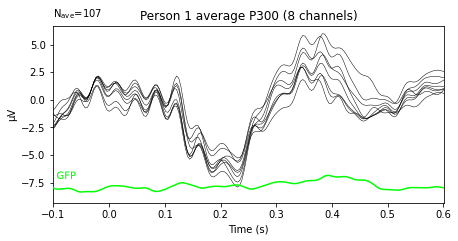

In [63]:
evokedP1 = P1l.average()
evokedP1.plot(gfp=True, titles='Person 1 average P300')

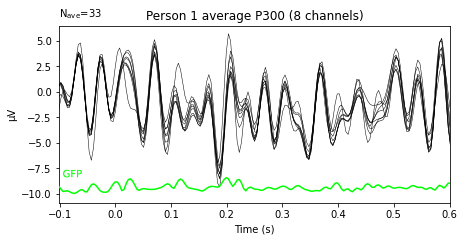

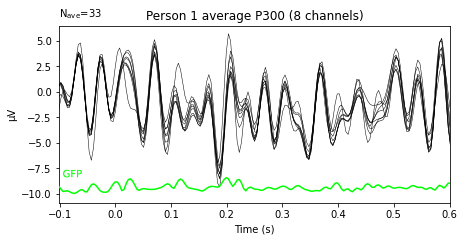

In [65]:
evokedP2 = P2l.average()
evokedP2.plot(gfp=True, titles='Person 1 average P300')

In [66]:
# run cross validation for each pipeline
acc = []
methods = []
for m in clfs:
    print(m)
    try:
        
        res = cross_val_score(clfs[m], X_final, y_final, scoring='accuracy', 
                              cv=cv, n_jobs=-1)
        print(res)
        acc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass

Vect + LR
[0.68571429 0.8        0.8        0.74285714 0.77142857 0.77142857
 0.71428571 0.8        0.74285714 0.82857143]
Vect + RegLDA
[0.68571429 0.77142857 0.82857143 0.82857143 0.71428571 0.8
 0.74285714 0.8        0.71428571 0.82857143]
ERPCov + TS
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ERPCov + MDM
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
XdawnCov + TS
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
XdawnCov + MDM
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


All four pipelines based on Riemannian geometry can distinguish between the presence or absence of ERP P300 response to stimuli with 100% accuracy

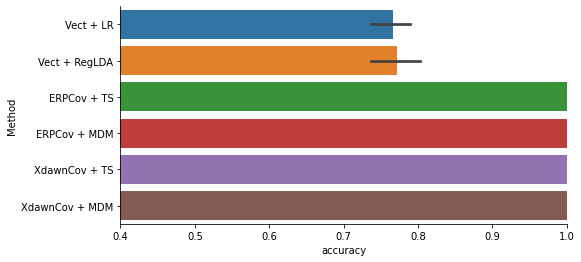

In [67]:
# Plot Decoding Results
results = pd.DataFrame(data=acc, columns=['accuracy'])
results['Method'] = methods

fig = plt.figure(figsize=[8,4])
sns.barplot(data=results, x='accuracy', y='Method')
plt.xlim(0.4, 1.0)
sns.despine()